# Practical assignment 6
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

Import libraries.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import chainer
from chainer import Variable
from chainer import datasets, iterators, optimizers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.dataset import convert
from chainer.datasets import TupleDataset

Hyperparameters.

In [2]:
batch_size = 32
n_epochs = 250

Helper function for getting the data.

In [3]:
def get_mnist(n_train=100, n_test=100, n_dim=1, with_label=True, classes=None):
    """

    :param n_train: nr of training examples per class
    :param n_test: nr of test examples per class
    :param n_dim: 1 or 3 (for convolutional input)
    :param with_label: whether or not to also provide labels
    :param classes: if not None, then it selects only those classes, e.g. [0, 1]
    :return:
    """

    train_data, test_data = chainer.datasets.get_mnist(ndim=n_dim, withlabel=with_label)

    if not classes:
        classes = np.arange(10)
    n_classes = len(classes)

    if with_label:

        for d in range(2):

            if d==0:
                data = train_data._datasets[0]
                labels = train_data._datasets[1]
                n = n_train
            else:
                data = test_data._datasets[0]
                labels = test_data._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i==0:
                    idx = lidx
                else:
                    idx = np.hstack([idx,lidx])

            L = np.concatenate([i*np.ones(n) for i in np.arange(n_classes)]).astype('int32')

            if d==0:
                train_data = TupleDataset(data[idx],L)
            else:
                test_data = TupleDataset(data[idx],L)

    else:

        tmp1, tmp2 = chainer.datasets.get_mnist(ndim=n_dim,withlabel=True)

        for d in range(2):

            if d == 0:
                data = train_data
                labels = tmp1._datasets[1]
                n = n_train
            else:
                data = test_data
                labels = tmp2._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i == 0:
                    idx = lidx
                else:
                    idx = np.hstack([idx, lidx])

            if d == 0:
                train_data = data[idx]
            else:
                test_data = data[idx]

    return train_data, test_data

Custom iterator.

In [4]:
class RandomIterator(object):
    """
    Generates random subsets of data
    """

    def __init__(self, data, batch_size=1):
        """

        Args:
            data (TupleDataset):
            batch_size (int):

        Returns:
            list of batches consisting of (input, output) pairs
        """

        self.data = data

        self.batch_size = batch_size
        self.n_batches = len(self.data) // batch_size

    def __iter__(self):

        self.idx = -1
        self._order = np.random.permutation(len(self.data))[:(self.n_batches * self.batch_size)]

        return self

    def next(self):

        self.idx += 1

        if self.idx == self.n_batches:
            raise StopIteration

        i = self.idx * self.batch_size

        # handles unlabeled and labeled data
        if isinstance(self.data, np.ndarray):
            return self.data[self._order[i:(i + self.batch_size)]]
        else:
            return list(self.data[self._order[i:(i + self.batch_size)]])

Get data.

In [5]:
train_data, _ = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0])

### 1. Implement a generator and a discriminator network. Use these to generate MNIST images. Plot the change in the loss for both networks.

Model definitions.

In [6]:
class Generator(Chain):
    def __init__(self):
        super(Generator, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 10 * 784)
            self.bn = L.BatchNormalization(7840)
            self.dc1 = L.Deconvolution2D(in_channels=10, out_channels=1, ksize=3, stride=1, pad=1, outsize=(28, 28))

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = self.bn(h)
        h = F.reshape(h, (-1, 10, 28, 28))
        h = self.dc1(h)
        return F.sigmoid(h)
    
class Discriminator(Chain):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c1 = L.Convolution2D(in_channels=1, 
                                      out_channels=1, 
                                      ksize=3, 
                                      stride=1, 
                                      pad=0)
            self.l1 = L.Linear(None, 1)
            
    def __call__(self, x):
        h = F.relu(self.c1(x))
        return self.l1(h)

Helper function for creating optimizers.

In [7]:
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    return optimizer

Setup models, optimizers and the iterator.

In [8]:
gen = Generator()
dis = Discriminator()

opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

train_iter = RandomIterator(train_data, batch_size)

Helper training function.

In [9]:
def train_GAN(gen, dis, opt_gen, opt_dis, train_iter, n_epochs, batch_size):
    
    losses_dis = []
    losses_gen = []
    
    for i in range(n_epochs):
        
        losses_dis_epoch = []
        losses_gen_epoch = []
        
        for batch in train_iter:
        
            noise_samples = np.random.uniform(0, 1, size=(batch_size, 1)).astype('float32')
            gen_samples = gen(noise_samples)
            real_samples = np.array(batch).reshape(batch_size, 1, 28, 28)

            y_fake = dis(gen_samples)
            y_real = dis(real_samples)

            loss_dis = F.sigmoid_cross_entropy(y_fake, np.zeros(y_fake.shape).astype(np.int32)) + \
                F.sigmoid_cross_entropy(y_real, np.ones(y_real.shape).astype(np.int32))
            losses_dis_epoch.append(loss_dis.data)
            dis.cleargrads()
            loss_dis.backward()
            opt_dis.update()

            loss_gen = F.sigmoid_cross_entropy(y_fake, np.ones(y_fake.shape, dtype=np.int32))
            losses_gen_epoch.append(loss_gen.data)
            gen.cleargrads()
            loss_gen.backward()
            opt_gen.update()
        
        losses_dis.append(np.array(losses_dis_epoch).mean())
        losses_gen.append(np.array(losses_gen_epoch).mean())
        
    return losses_dis, losses_gen

Train the GAN, save the losses.

In [10]:
losses_dis, losses_gen = train_GAN(gen, dis, opt_gen, opt_dis, train_iter, n_epochs, batch_size)

Plot the losses during training.

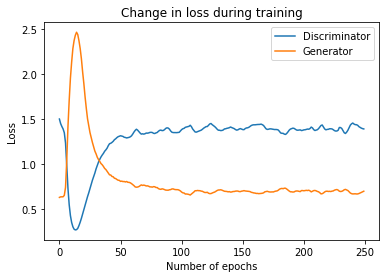

In [11]:
plt.plot(losses_dis)
plt.plot(losses_gen)
plt.title("Change in loss during training")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
_ = plt.legend(["Discriminator", "Generator"])

### 2. Generate 10 samples using the generator. Comment on your results.

Generate some samples and plot them.

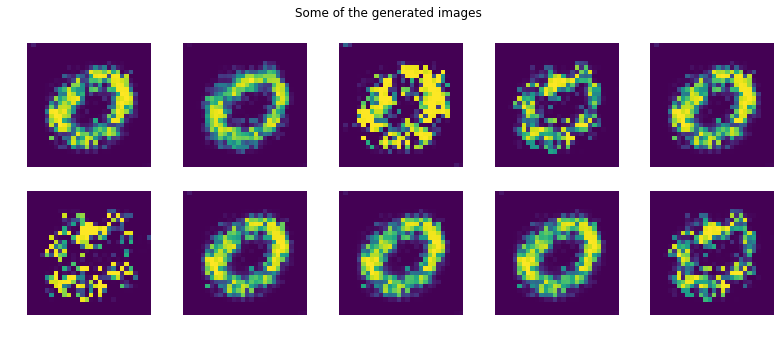

In [12]:
noise_samples = np.random.uniform(0, 1, size=(10, 1)).astype('float32')
gen_samples = gen(noise_samples)
gen_pics = gen_samples.data

f, axes = plt.subplots(2, 5, sharey=True, figsize=(13.5, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(gen_pics[i].reshape(28, 28).T)
    plt.axis('off')
_ = plt.suptitle("Some of the generated images")

The generator can create sensible zeroes, though some of them still leave a lot to be desired. It is most likely possible to tune the architecture to produce better results.